In [2]:
import pandas as pd

In [5]:
df = pd.read_json("ascii_art_data.json")


In [6]:
print(df['text'][1])

       _.---._    /\\
    ./'       "--`\//
  ./              o \          .-----.
 /./\  )______   \__ \        ( help! )
./  / /\ \   | \ \  \ \       /`-----'
   / /  \ \  | |\ \  \7--- ooo ooo ooo ooo ooo ooo


In [8]:
# prompt: create a variable called ASCII_TEXT which is a list of all the df['text'] items where the width is less than 32 AND the height is less than 32. You might have to first calculate the width and height for each item before filtering since they're just strings. Width in this case is the width of the longest line, not the average width of the ascii image

import pandas as pd

df = pd.read_json("ascii_art_data.json")

df['width'] = df['text'].apply(lambda x: max(len(line) for line in x.splitlines()))
df['height'] = df['text'].apply(lambda x: len(x.splitlines()))

ASCII_TEXT = df[ (df['width'] < 32) & (df['height'] < 32) ]['text'].tolist()
len(ASCII_TEXT)


2108

In [9]:
import torch
from transformers import AutoTokenizer

class ASCIITokenizer:
    def __init__(self):
        self.vocab = [chr(i) for i in range(32, 127)]  # printable ASCII characters
        self.vocab_size = len(self.vocab)
        self.token_to_char = {i: c for i, c in enumerate(self.vocab)}
        self.char_to_token = {c: i for i, c in enumerate(self.vocab)}

    def tokenize(self, text):
        tokens = [self.char_to_token[c] for c in text if c in self.vocab]
        return tokens

tokenizer = ASCIITokenizer()

tokenized_data = []
for ascii_art in ASCII_TEXT:
    tokens = tokenizer.tokenize(ascii_art)
    tokenized_data.append(tokens)

print(f'Num Unique Tokens: {len(tokenizer.token_to_char)}')

Num Unique Tokens: 95


One thing to note is that the tokenization here tokenizes each character individually, meaning that `\` and `n` are individual tokens, I think it'll be fine and the model will learn that they should be combined for a new line but I don't know if we have enough data and time for it to properly learn that.

I think the padding I'm doing underneath is definitely an area we gotta do some more experimentation on. Right now it's just flattening the art into a long string and padding it at the end but it might be better to add padding in between to center the image. Not sure.

In [10]:
def pad_ascii_art(ascii_art, max_width=32, max_height=32, pad_char=' '):
    lines = ascii_art.splitlines()
    padded_lines = [line.ljust(max_width, pad_char) for line in lines]
    while len(padded_lines) < max_height:
        padded_lines.append(pad_char * max_width)
    return '\n'.join(padded_lines)

padded_data = [pad_ascii_art(art) for art in ASCII_TEXT]

# Tokenize the padded data
tokenized_data = [tokenizer.tokenize(art) for art in padded_data]

# Convert to tensor and pad to 32x32 (1024 tokens)
max_length = 32 * 32
tokenized_data = [tokens + [0] * (max_length - len(tokens)) for tokens in tokenized_data]
tokenized_data = torch.tensor(tokenized_data)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(tokenized_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Modeling

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # for mean and log variance
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

In [22]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [24]:
# Parameters
input_dim = 32 * 32  # 1024
hidden_dim = 512
latent_dim = 64
lr = 0.001
num_epochs = 50

# Model, optimizer, and loss function
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
vocab_size = 95  # Number of printable ASCII characters
tokenized_data = tokenized_data.float() / vocab_size

In [28]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch[0].float() / vocab_size
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset)}')

Epoch 1, Loss: 210.8883853456327
Epoch 2, Loss: 137.3592195746116
Epoch 3, Loss: 133.83079514331564
Epoch 4, Loss: 129.1705778581594
Epoch 5, Loss: 126.31899068930117
Epoch 6, Loss: 123.30519025827947
Epoch 7, Loss: 121.30071662454044
Epoch 8, Loss: 119.97072536171727
Epoch 9, Loss: 118.78508571791242
Epoch 10, Loss: 118.2915747857863
Epoch 11, Loss: 117.82751997598434
Epoch 12, Loss: 117.19477418613614
Epoch 13, Loss: 116.37714132638312
Epoch 14, Loss: 116.17135266877668
Epoch 15, Loss: 115.46657751904945
Epoch 16, Loss: 115.09399842582572
Epoch 17, Loss: 114.74855415011267
Epoch 18, Loss: 114.07342262919532
Epoch 19, Loss: 113.61534579021881
Epoch 20, Loss: 112.96608414188508
Epoch 21, Loss: 112.65668685884133
Epoch 22, Loss: 112.09649855090726
Epoch 23, Loss: 111.51719813193044
Epoch 24, Loss: 111.36693710529826
Epoch 25, Loss: 111.00548482529352
Epoch 26, Loss: 110.42333463201939
Epoch 27, Loss: 110.00803058197195
Epoch 28, Loss: 109.86490337219817
Epoch 29, Loss: 109.5405399677197

Generated ASCII Art 1:
     !!"##$&*/024-1'$##!        
  !!"$%)0+*/23;?GH09()('! "     
! ""$).).1-1//7>97>?-(('##"     
"##"'&+0-44:85831?<?93(&"""!    
&*)#*.4;4459?79>HITJJL44)%&)    
/13&,.;<=DOIQAJEHJXWXQM90+.(!   
/'+$*.4.5157A:88<CE6=.+/($)&    
'$&"$%-1.0/7/06;9630401%%%-"    
,*+!$$*%*-0+-(3-(,*&$#""#!"!    
!## ! !!!"$$$"""!!"!!!#!! #     
        !!!""!!!! !#!!!"  #     
          !!!""""! !!!!         
           !! !                 
                                
           ! !     "            
              !!                
                                
                                
                                
                                
                                
                                
                                
                                
                                
                                
                                
                                
                                
                    

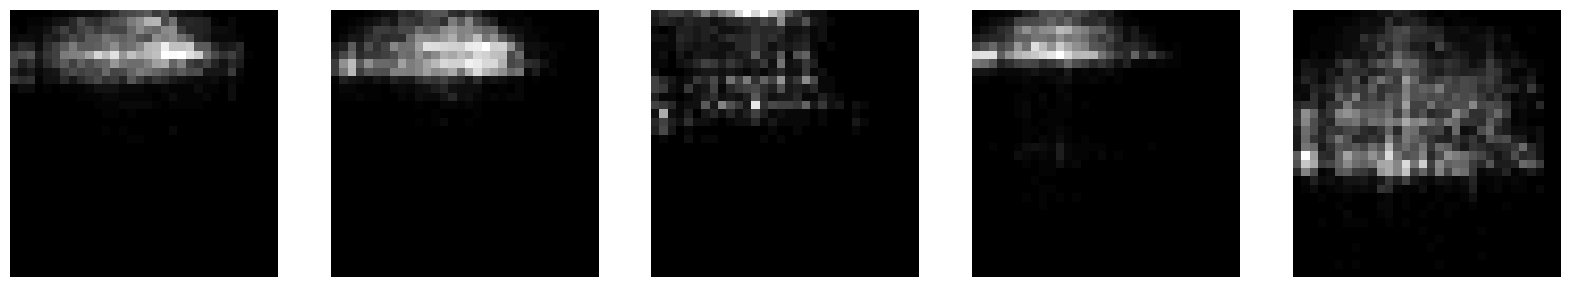

In [30]:
import matplotlib.pyplot as plt

def generate_ascii_art(model, num_images):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(num_images, model.decoder[0].in_features).float()
        # Generate images by passing the latent vectors through the decoder
        generated_images = model.decoder(z)

    # Denormalize the generated images (values from 0 to 1 back to 0 to 94)
    generated_images = (generated_images * vocab_size).int().clamp(0, vocab_size - 1)

    # Convert generated tokens back to ASCII characters
    generated_ascii_art = []
    for image in generated_images:
        tokens = image.numpy().reshape(32, 32)  # Reshape to 32x32
        ascii_art = '\n'.join(''.join(tokenizer.token_to_char[token] for token in row) for row in tokens)
        generated_ascii_art.append(ascii_art)

    return generated_ascii_art

# Generate 5 images
NUM_IMAGES = 5
generated_images = generate_ascii_art(model, NUM_IMAGES)

# Print the generated ASCII art images
for i, art in enumerate(generated_images):
    print(f"Generated ASCII Art {i + 1}:\n{art}\n{'-'*40}")

# Optional: Plot the generated ASCII art images using matplotlib (if desired)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, art in enumerate(generated_images):
    axes[i].imshow([[ord(char) for char in line] for line in art.split('\n')], cmap='gray')
    axes[i].axis('off')
plt.show()